# Objectives

1. Plot Locus Coverage of Whole Genome.
1. Add Locus Coverage to Dataframe.
1. Plot Locus Coverage: Distribution.
1. Plot Locus Coverage: Phlyo.
1. Identify Interesting Samples.

---
# Setup

## Imports

In [3]:
import os
import dill
from Bio import Phylo
import copy
import math
import pandas as pd
from matplotlib import lines, patches, colors, gridspec
import seaborn as sns

## Variables

In [4]:
from config import *

# Custom script variables
SCRIPT_NAME = "locus_coverage_collect"
PREV_DIR_NAME = "mugration"
PREV_SCRIPT_NAME = "mugration_model"

try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    #WILDCARDS = ["all", "chromosome", "50"]
    WILDCARDS = ["all", "chromosome", "5"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
MISSING_DATA = WILDCARDS[2]

NAME_COL = "Name"

pd.set_option("display.max_rows", 10, "display.max_columns", 10)

## File Paths

In [5]:
config_dir = os.path.join(project_dir, "config")
results_dir = os.path.join(project_dir, "results")


outdir       = os.path.join(results_dir, SCRIPT_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),)
#tree_dill    = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),PREV_SCRIPT_NAME + "_timetree.treetime.obj")
#tree_df_dill = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".df.obj")
tree_df_path = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".tsv")
tree_path    = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + "_timetree.nwk")

ref_gff_path = os.path.join(results_dir,"data/reference/GCA_000009065.1_ASM906v1_genomic/GCA_000009065.1_ASM906v1_genomic.gff.index")
aln_path     = os.path.join(results_dir,"snippy_multi",READS_ORIGIN,"snippy-core_{}.snps.filter{}.aln".format(LOCUS_NAME, MISSING_DATA))

# Auspice
auspice_latlon_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_latlon.tsv")
auspice_colors_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_colors.tsv")
auspice_config_path = os.path.join(config_dir, "auspice_config.json")
auspice_remote_dir_path = os.path.join(project_dir, "auspice/")

# Uniq
cov_df_path  = os.path.join(results_dir, SCRIPT_NAME, READS_ORIGIN, "locus_coverage" + ".txt")
dep_df_path  = os.path.join(results_dir, SCRIPT_NAME, READS_ORIGIN, "locus_depth" + ".txt")

print("tree_path:\t", tree_path)
print("tree_df_path:\t", tree_df_path)
print("aln path:\t", aln_path)
print("auspice_latlon_path:", auspice_latlon_path)
print("auspice_colors_path:", auspice_colors_path)
print("auspice_config_path:", auspice_config_path)
print("auspice_remote_dir_path:", auspice_remote_dir_path)
print("outdir:", outdir)

# Create output directory if it doesn't exist
while not os.path.exists(outdir):
    os.makedirs(outdir)   
    
SCRIPT_NAME = "locus_coverage_collect"

tree_path:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/mugration/all/chromosome_filter5/mugration_model_timetree.nwk
tree_df_path:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/mugration/all/chromosome_filter5/mugration_model.tsv
aln path:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/snippy_multi/all/snippy-core_chromosome.snps.filter5.aln
auspice_latlon_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_latlon.tsv
auspice_colors_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_colors.tsv
auspice_config_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/config/auspice_config.json
auspice_remote_dir_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/auspice/
outdir: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/locus_coverage_collect/all/chromosome_filter5


## Import Tree

In [6]:
#with open(tree_dill, "rb") as infile:
#    tt = dill.load(infile)
#tt.tree.ladderize(reverse=False)

tree = Phylo.read(tree_path, "newick")
tree.ladderize(reverse=False)

## Import Tree Dataframe

In [7]:
#with open(tree_df_dill, "rb") as infile:
#    tree_df = dill.load(infile)
#tree_df


tree_df = pd.read_csv(tree_df_path, sep='\t')
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index(NAME_COL, inplace=True)
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,...,Mugration_Province,Mugration_Province_Confidence,Mugration_Province_Entropy,Mugration_Province_Lat,Mugration_Province_Lon
Name,,,,,,,,,,,
NODE0,100,NA,0,black,0.001000,...,Krasnoyarsk Krai,0.382134,1.653172e+00,63.323381,97.097997
SAMEA3541827,NA,NA,3.8504e-06,grey,0.001003,...,Krasnoyarsk Krai,1.000000,-9.998669e-13,63.323381,97.097997
NODE1,100,85,1.32708e-05,black,0.001008,...,Panevezys County,0.442454,1.927184e+00,55.915605,25.031160
SAMEA104233046,NA,NA,2.2484e-06,grey,0.001010,...,Panevezys County,1.000000,-1.000089e-12,55.915605,25.031160
NODE2,100,94.6,1.36364e-05,black,0.001022,...,Pärnu maakond,0.442527,1.922557e+00,58.319507,24.302612
...,...,...,...,...,...,...,...,...,...,...,...
NODE_0000435,NA,NA,NA,NA,0.001065,...,Midlands,0.366411,1.733872e+00,-19.278504,29.879085
NODE_0000404,NA,NA,NA,NA,0.001068,...,Cajamarca,0.999998,3.260546e-05,-6.250000,-78.833333
NODE_0000460,NA,NA,NA,NA,0.001068,...,La Libertad,0.999998,3.676505e-05,-8.000000,-78.500000


## Import Locus Dataframes

In [8]:
cov_df = pd.read_csv(cov_df_path, sep='\t')
cov_df.set_index("Sample", inplace=True)
cov_df_samples = cov_df.index

#dep_df = pd.read_csv(dep_df_path, sep='\t')
#dep_df.set_index(NAME_COL, inplace=True)
#dep_df_samples = dep_df.index

# Remove samples not in tree dataframe
for sample in cov_df_samples:
    if sample not in tree_df.index:
        cov_df.drop(sample, inplace=True)
        #dep_df.drop(sample, inplace=True)
        
display(cov_df)        
#display(dep_df)

,AL590842.1:1..4653728,gene-YPO0001,cds-CAL18691.1,gene-YPO0002,cds-CAL18692.1,...,gene-YPPCP1.08c,cds-CAB53171.1,gene-YPPCP1.09c,cds-CAB53172.1,id-AL109969.1:8528..8532
Sample,,,,,,,,,,,
GCA_000006645.1_ASM664v1_genomic,0.954739,1.000000,1.000000,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.0
GCA_000007885.1_ASM788v1_genomic,0.949741,1.000000,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.0
GCA_000013825.1_ASM1382v1_genomic,0.957765,1.000000,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.0
GCA_000022805.1_ASM2280v1_genomic,0.963296,1.000000,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.0
GCA_000022825.1_ASM2282v1_genomic,0.963309,1.000000,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7293136,0.930136,1.000000,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.0
SAMEA7313236_38,0.943375,1.000000,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.0
SAMEA7313243_45,0.918001,0.988662,0.988662,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.0


## Import Reference GFF

In [9]:
ref_df = pd.read_csv(ref_gff_path, sep='\t')
ref_df.set_index("id", inplace=True)
display(ref_df)

ref_rep_df = ref_df[ref_df["type"] == "region"]
display(ref_rep_df)

ref_gene_df = ref_df[ref_df["type"] == "gene"]
display(ref_gene_df)

,loci,type,start,end
id,,,,
AL590842.1:1..4653728,AL590842,region,1,4653728
gene-YPO0001,AL590842,gene,271,711
cds-CAL18691.1,AL590842,CDS,271,711
gene-YPO0002,AL590842,gene,804,1265
cds-CAL18692.1,AL590842,CDS,804,1265
...,...,...,...,...
gene-YPPCP1.08c,AL109969,gene,7790,8089
cds-CAB53171.1,AL109969,CDS,7790,8089
gene-YPPCP1.09c,AL109969,gene,8089,8436


,loci,type,start,end
id,,,,
AL590842.1:1..4653728,AL590842,region,1,4653728
AL117189.1:1..70305,AL117189,region,1,70305
AL117211.1:1..96210,AL117211,region,1,96210
AL109969.1:1..9612,AL109969,region,1,9612


,loci,type,start,end
id,,,,
gene-YPO0001,AL590842,gene,271,711
gene-YPO0002,AL590842,gene,804,1265
gene-YPO0003,AL590842,gene,1435,2427
gene-YPO0004,AL590842,gene,2526,3992
gene-YPO0005,AL590842,gene,3996,5549
...,...,...,...,...
gene-YPPCP1.05c,AL109969,gene,4815,5888
gene-YPPCP1.06,AL109969,gene,6006,6422
gene-YPPCP1.07,AL109969,gene,6665,7603


## Separate Dataframe by Type

In [10]:
cov_rep_df = copy.deepcopy(cov_df)
cov_gene_df = copy.deepcopy(cov_df)
non_replicon_loci = []
non_gene_loci = []

for col in cov_df.columns:
    if col not in ref_rep_df.index:
        non_replicon_loci.append(col)
    if col not in ref_gene_df.index:
        non_gene_loci.append(col)
        
cov_rep_df.drop(columns=non_replicon_loci, inplace=True)
display(cov_rep_df)
       
cov_gene_df.drop(columns=non_gene_loci, inplace=True)
display(cov_gene_df)

,AL590842.1:1..4653728,AL117189.1:1..70305,AL117211.1:1..96210,AL109969.1:1..9612
Sample,,,,
GCA_000006645.1_ASM664v1_genomic,0.954739,0.011763,0.949797,0.000000
GCA_000007885.1_ASM788v1_genomic,0.949741,0.960330,0.937065,0.819600
GCA_000013825.1_ASM1382v1_genomic,0.957765,0.960501,0.929643,0.817936
GCA_000022805.1_ASM2280v1_genomic,0.963296,0.960387,0.949579,0.819392
GCA_000022825.1_ASM2282v1_genomic,0.963309,0.960487,0.948010,0.819496
...,...,...,...,...
SAMEA7293136,0.930136,0.943958,0.901299,0.810029
SAMEA7313236_38,0.943375,0.949335,0.616984,0.807948
SAMEA7313243_45,0.918001,0.937159,0.936088,0.802434


,gene-YPO0001,gene-YPO0002,gene-YPO0003,gene-YPO0004,gene-YPO0005,...,gene-YPPCP1.05c,gene-YPPCP1.06,gene-YPPCP1.07,gene-YPPCP1.08c,gene-YPPCP1.09c
Sample,,,,,,,,,,,
GCA_000006645.1_ASM664v1_genomic,1.000000,1.0,1.000000,1.000000,1.0,...,0.000000,0.00000,0.000000,0.000000,0.000000
GCA_000007885.1_ASM788v1_genomic,1.000000,1.0,1.000000,1.000000,1.0,...,1.000000,1.00000,1.000000,1.000000,1.000000
GCA_000013825.1_ASM1382v1_genomic,1.000000,1.0,1.000000,1.000000,1.0,...,1.000000,1.00000,1.000000,1.000000,1.000000
GCA_000022805.1_ASM2280v1_genomic,1.000000,1.0,1.000000,1.000000,1.0,...,1.000000,1.00000,1.000000,1.000000,1.000000
GCA_000022825.1_ASM2282v1_genomic,1.000000,1.0,1.000000,1.000000,1.0,...,1.000000,1.00000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7293136,1.000000,1.0,1.000000,0.983640,1.0,...,1.000000,1.00000,1.000000,1.000000,1.000000
SAMEA7313236_38,1.000000,1.0,1.000000,1.000000,1.0,...,1.000000,1.00000,1.000000,1.000000,1.000000
SAMEA7313243_45,0.988662,1.0,0.985901,0.974778,1.0,...,1.000000,1.00000,0.954207,1.000000,1.000000


## Import Colors

In [11]:
colors_df = pd.read_csv(auspice_colors_path, sep='\t', header=None)
colors_df.columns = ["Attribute", "State", "Color"]
colors_df.fillna(NO_DATA_CHAR, inplace=True)
display(colors_df)

colors_dict = {}
# Convert to dict

for rec in colors_df.iterrows():
    attr = rec[1]["Attribute"]
    state = rec[1]["State"]
    color = rec[1]["Color"]
    if attr not in colors_dict:
        colors_dict[attr] = {}
    colors_dict[attr][state] = color

,Attribute,State,Color
0,branch_number,0,#8000ff
1,branch_number,3,#00b4ec
2,branch_number,4,#80ffb4
3,branch_number,2,#ffb462
4,branch_number,1,#ff0000
...,...,...,...
202,province,Midlands,#ff1c0e
203,province,State of Mato Grosso,#ff150b
204,province,MSila,#ff0e07
205,province,La Paz,#ff0704


## Setup CMAP

In [12]:
cmap = plt.cm.RdYlGn
norm = colors.Normalize(vmin=0, vmax=1)

---
# 1. Plot Locus Coverage of Whole Genome

## Axes Metadata

In [13]:
axes_dict = {
    "Tree" : {
        "prop" : 12,
        "title" : "Time Tree",
        "xlabel" : "Year",
        "key" : "Tree",
        "i" : 0,
        "xmax"   : 0,       
    },
    "Clade" : {
        "prop" : 1,
        "title" : "Clade",
        "xlabel" : "",        
        "key" : "Clade",
        "i" : 1,  
        "xmax"   : 0,        
    },    
    "AL590842.1:1..4653728" : {
        "prop" : 6,
        "title" : "Chromosome",
        "xlabel" : "Coordinate",        
        "key" : "YPO",
        "i" : 2,  
        "xmax"   : 4653728,        
    },
    "AL117189.1:1..70305": {
        "prop" : 2,
        "title" : "pCD1",      
        "xlabel" : "Coordinate", 
        "key" : "YPCD1",   
        "i" : 3,  
        "xmax"   : 70305,       
    },
    "AL117211.1:1..96210": {
        "prop" : 2,
        "title" : "pMT1",     
        "xlabel" : "Coordinate",
        "key" : "YPMT1",   
        "i" : 4,        
        "xmax"   : 96210,      
    },
    "AL109969.1:1..9612": {
        "prop"   : 2,
        "title"  : "pPCP1", 
        "xlabel" : "Coordinate",
        "key"    : "YPPCP1",   
        "i"      : 5,
        "xmax"   : 9612,
    },
}

## Axes Setup

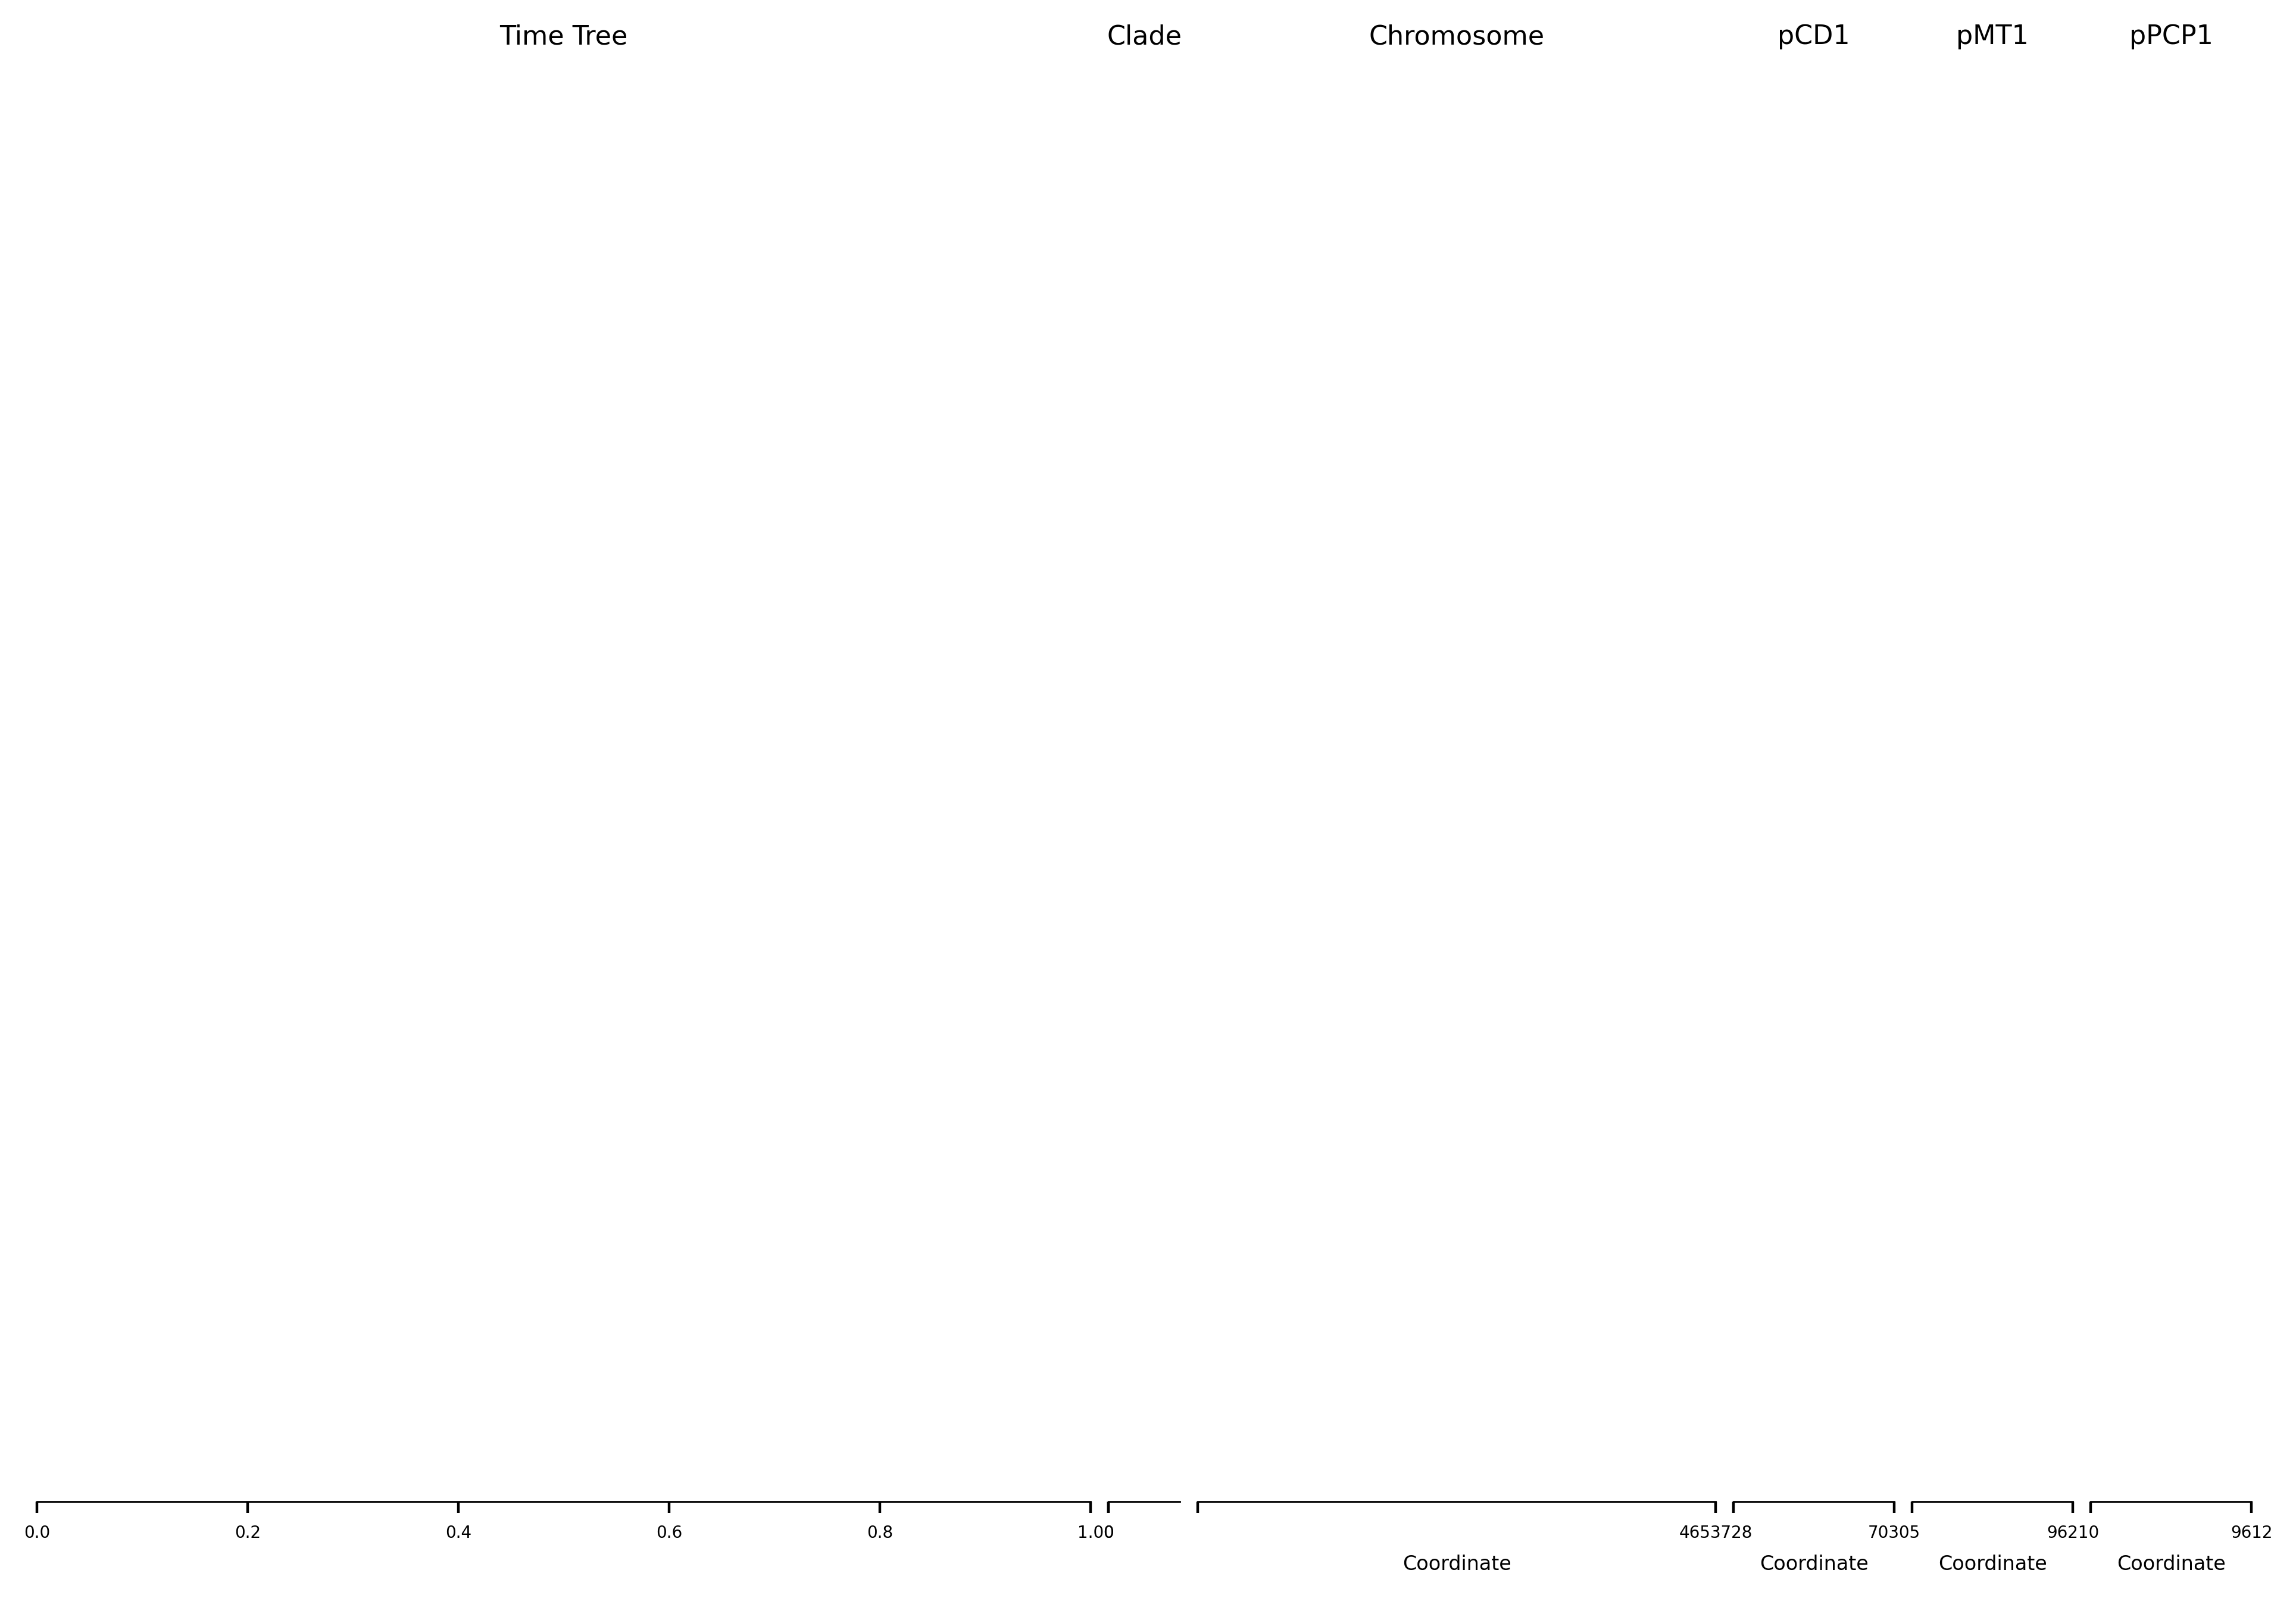

In [31]:
fig_gene = plt.figure(figsize=(12,8), dpi=dpi)

total_col = sum([axes_dict[ax]["prop"] for ax in axes_dict])
gs = gridspec.GridSpec(1, total_col, figure=fig_gene, wspace=0.25, hspace=0)

axes = []
i_ax = 0
i_prev = 0
for ax in axes_dict:
    i_cur = i_prev + axes_dict[ax]["prop"]
    if len(axes) > 0:
        axes += [fig_gene.add_subplot(gs[0, i_prev:i_cur], sharey=axes[0])]
    else:
        axes += [fig_gene.add_subplot(gs[0, i_prev:i_cur],)]
    i_prev = i_cur
    axes[i_ax].set_title(axes_dict[ax]["title"], fontsize=8)
    
    # Spines
    for s in axes[i_ax].spines:
        axes[i_ax].spines[s].set_linewidth(0.5)
    axes[i_ax].spines["right"].set_visible(False)
    axes[i_ax].spines["top"].set_visible(False)
    axes[i_ax].spines["left"].set_visible(False)  
    
    # X-Axis
    if i_ax != 0:
        axes[i_ax].set_xticks([0, axes_dict[ax]["xmax"]])
        axes[i_ax].set_xticklabels([""] + [str(axes_dict[ax]["xmax"])])
        axes[i_ax].set_xlabel(axes_dict[ax]["xlabel"], fontsize=6)
    # Y-Axis
    axes[i_ax].set_yticks([])
        
    i_ax += 1

## Clade

In [32]:
tip_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
#axes[0].scatter(data=tip_data, x="timetree_coord_x", y="timetree_coord_y", s=0.5, c="grey")

i_ax = axes_dict["Clade"]["i"]
for rec in tip_data.iterrows():
    y = rec[1]["timetree_coord_y"]
    state = rec[1]["Branch_Major"]
    color = colors_dict["branch_major"][state]
    axes[i_ax].plot([0, 1], [y,y], alpha=1, c=color, linewidth=1)

axes[i_ax].set_xticks([])
axes[i_ax].spines["bottom"].set_visible(False) 

## Add Phylogeny

In [33]:
# ---------------------------------------
# Phylogeny
tree_copy = copy.deepcopy(tree)

# Setup color
for c in tree_copy.find_clades():
    state = tree_df["Mugration_Branch_Major"][c.name]
    state_conf = tree_df["Mugration_Branch_Major_Confidence"][c.name]
    color = colors_dict["branch_major"][state]
    # Reset to grey low confidence
    c.color = "grey"
    if state_conf >= MUG_CONF_THRESH:
        c.color = color

# Phylogeny Lines
Phylo.draw(tree_copy,
           axes=axes[0],
           show_confidence=False, 
           label_func = lambda x: '', 
           do_show=False,
          )

# Node Bars
x_min = 0
#if hasattr(tt_copy.tree.root, "marginal_inverse_cdf"):
# Need to invert the node bar units
#present_date = abs(tt_copy.tree.root.numdate - CURRENT_YEAR)
present_date = abs(tree_df["timetree_num_date"][tree.root.name] - CURRENT_YEAR)
for rec in tree_df.iterrows():
    conf_bar = rec[1]["timetree_num_date_bar"]
    if type(conf_bar) == str:        
        conf_bar = ast.literal_eval(conf_bar)
    bar_lower = present_date - int(conf_bar[0])
    bar_upper = present_date - int(conf_bar[1])
    y = rec[1]["timetree_coord_y"]
    axes[0].plot([bar_lower, bar_upper], [y,y], alpha=0.5, c="grey", linewidth=2)

    # Possibly update axis x-limits
    if bar_lower < x_min:
        x_min = bar_lower
            
#fig_gene

## Heatmap

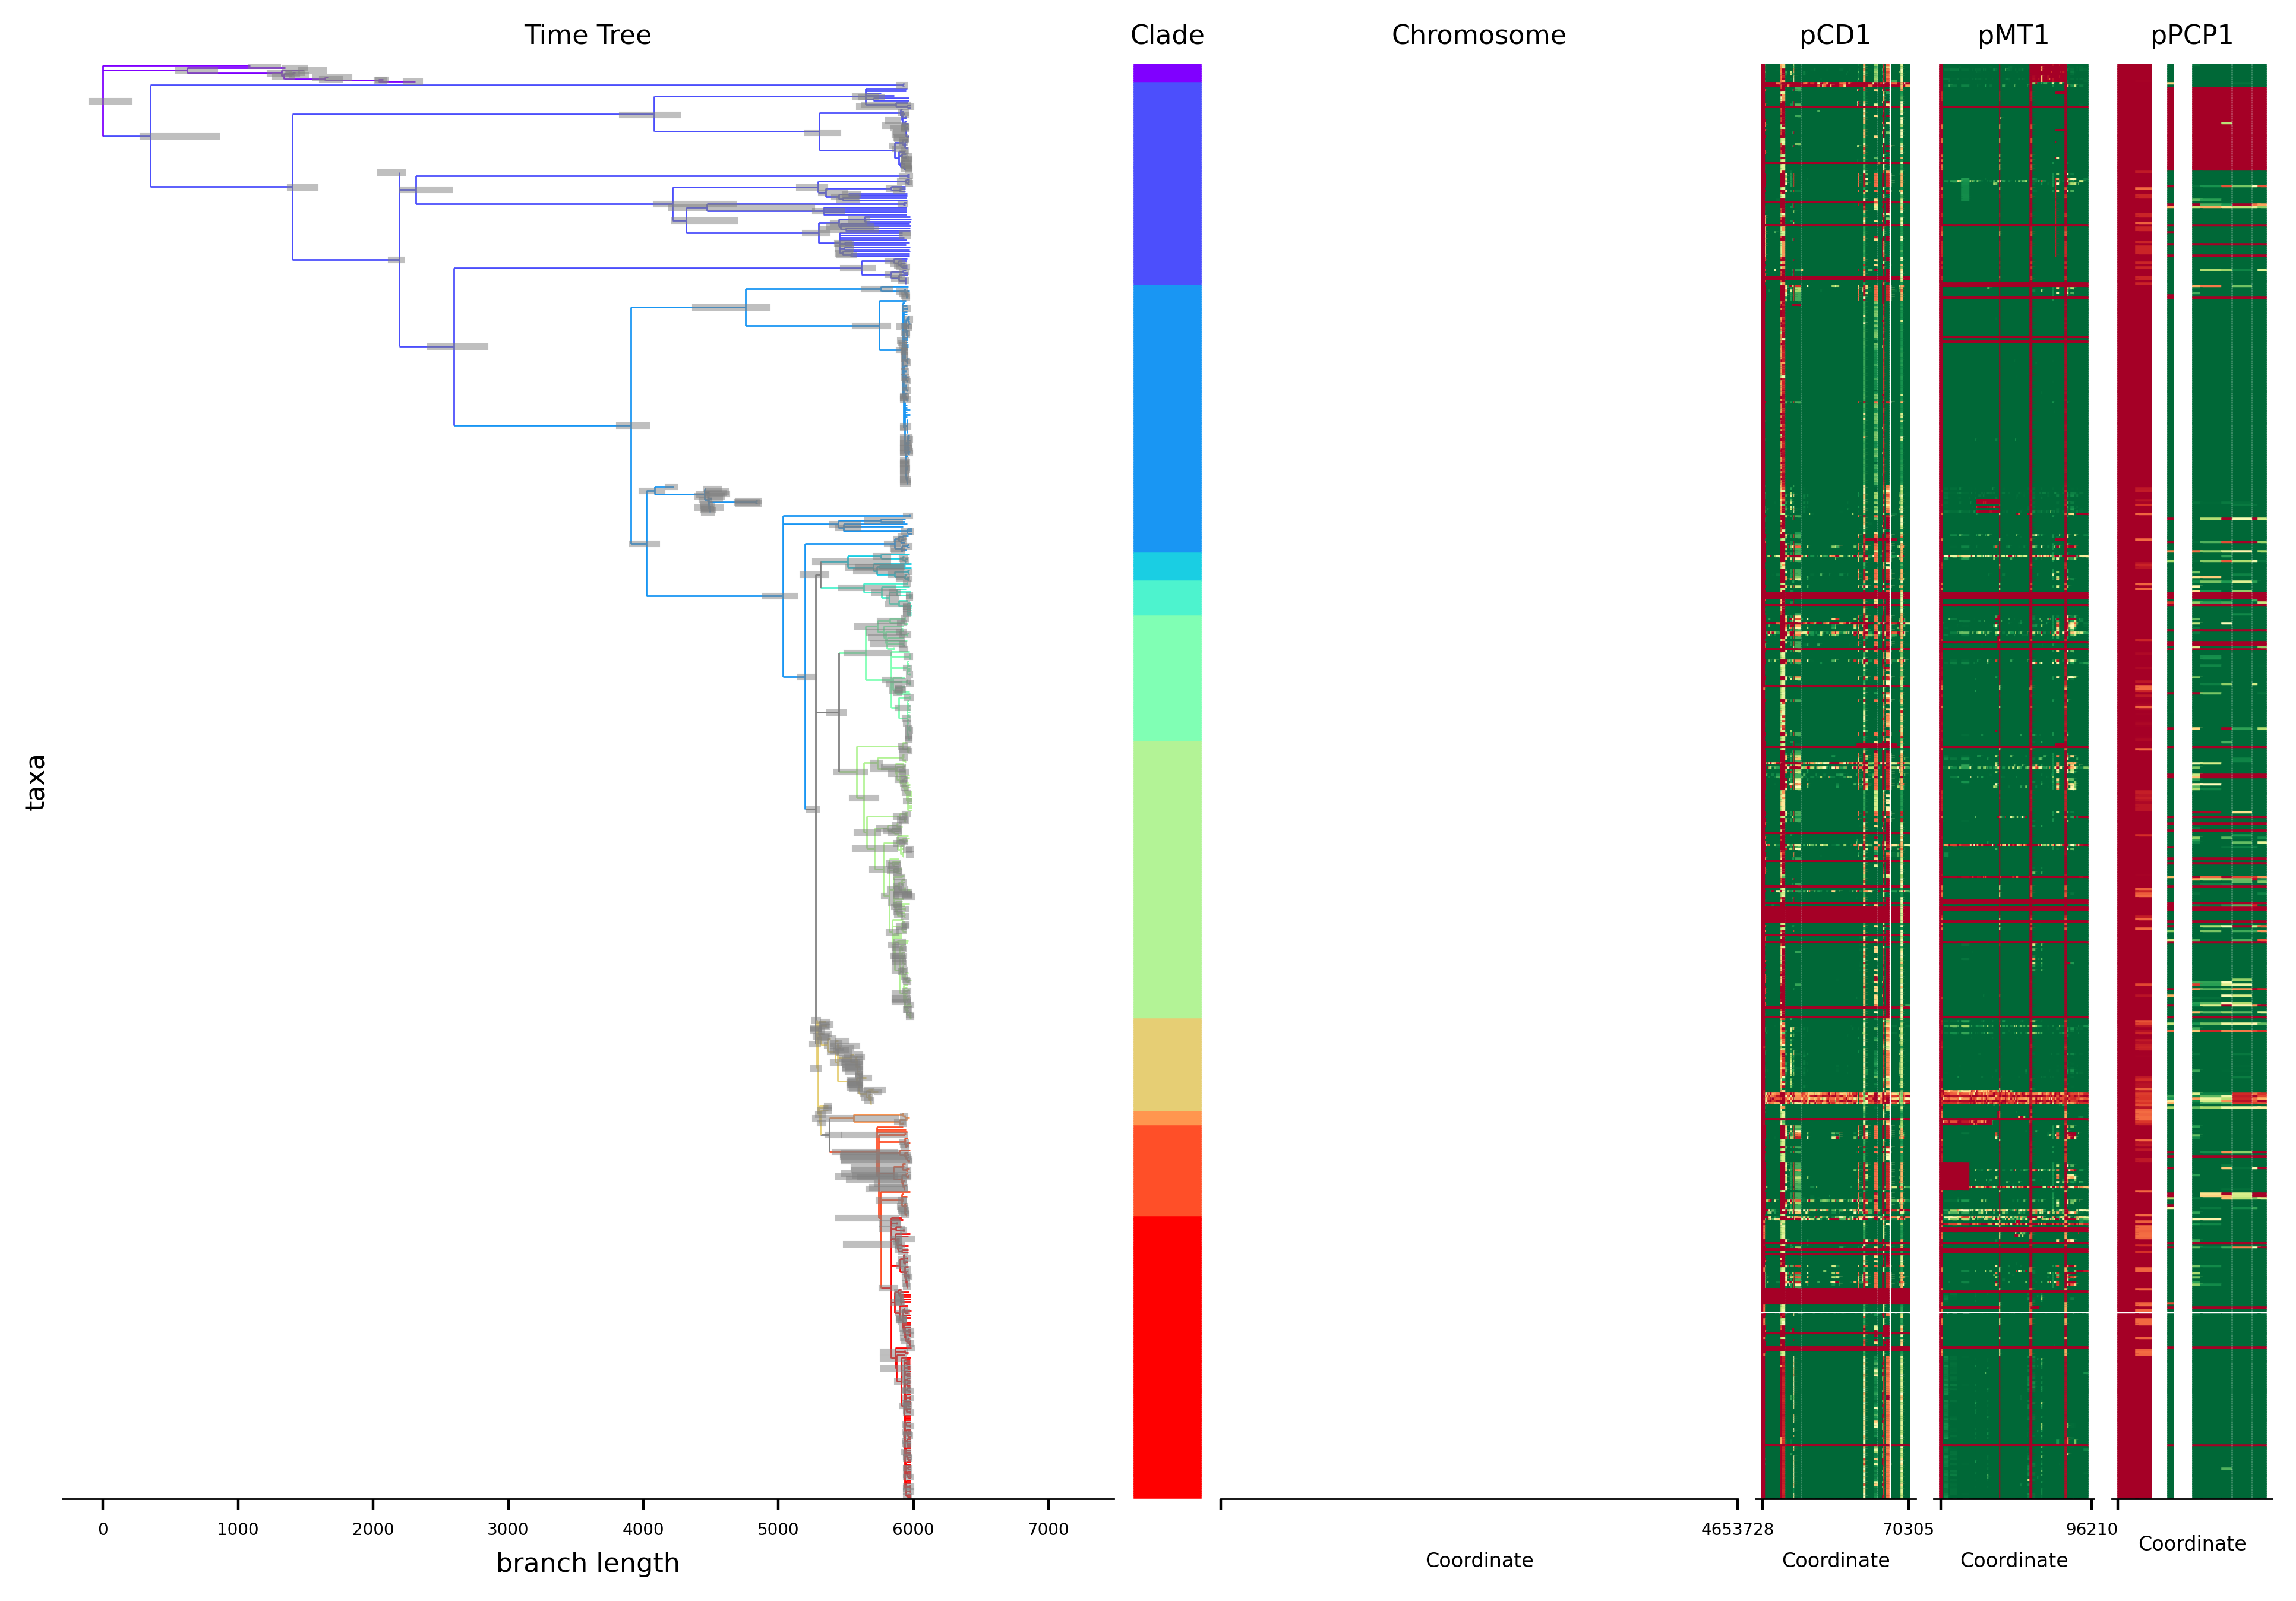

In [34]:
# --------------------------------------------------------------
# Heatmap Gene Coverage
sample_i = 0
#sample_i_target = 50
sample_i_target = len(tree.get_terminals())
gene_i_target = 100

#df.set_index("gene", inplace=True)

# Iterate Through Samples in the Tree
for node in tree.get_terminals(): 
    sample_i += 1    
    if sample_i > sample_i_target:
        break
    
    sample = node.name
    if sample not in cov_gene_df.index: continue    
    y = tree_df["timetree_coord_y"][sample]
    
    # Iterate through loci
    i_ax = 1
    for loci in ref_rep_df["loci"]:
        i_ax += 1
        # Iterate through genes
        #if loci != "AL109969": continue
        if loci == "AL590842": continue
        loci_gene_df = ref_gene_df[ref_gene_df["loci"] == loci]
        plot_df = pd.DataFrame({"gene" : [], "x_start" : [], "x_end" : [], "y" : [], "cov" : [], "color" : []})
        gene_i = 0
        for gene in loci_gene_df.index:
            gene_i += 1    
            if gene_i > gene_i_target:
                break
            x_start = ref_gene_df["start"][gene]
            x_end = ref_gene_df["end"][gene]
            cov = cov_gene_df[gene][sample]
            color = cmap(norm(cov))
            axes[i_ax].plot([x_start, x_end], [y,y], alpha=1, c=color, linewidth=1)

fig_gene

## Legend

In [35]:
clade_lines = [lines.Line2D([0], [0], color=colors_dict["branch_major"][state], lw=4) 
                for state in colors_dict["branch_major"]]
clade_labels = [state for state in colors_dict["branch_major"]]

clade_legend = fig_gene.legend(clade_lines, 
           clade_labels,
           ncol=len(clade_labels),
           loc="center", 
           bbox_to_anchor=(0.5, 0),
           #bbox_to_anchor=(0.14,-0.13),
           frameon=True,
           borderpad=1.0,
           edgecolor="black",
           title="Clade",
           title_fontsize=10,
           fontsize=8,
          )

#fig_gene

## Save Figure

In [36]:
out_path = os.path.join(outdir, SCRIPT_NAME + "_phylo-gene." + FMT)
fig_gene.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
# 1. Add Locus Info to Dataframe

In [ ]:
for locus in locus_df.columns:
    tree_df[locus] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
    for i in range(0, len(locus_df[locus])):
        sample = locus_df.index[i]
        if sample not in tree_df.index: continue
        cov = locus_df[locus][i]
        tree_df.at[sample, locus] = cov

display(tree_df)


In [ ]:
# add ratios
locus = ["pPCP1"]
gene = ["pla"]

for l,g in zip(locus, gene):
    ratio_col = l + "_" + g + "_dep_ratio"
    tree_df[ratio_col] = [NO_DATA_CHAR for row in range(0,len(tree_df))]
    ratio_df = locus_df[[l + "_dep", g + "_dep"]]
    for rec in ratio_df.iterrows():
        sample = rec[0]
        l_dep = rec[1][l + "_dep"]
        g_dep = rec[1][g + "_dep"]
        if l_dep == 0 or g_dep == 0 or l_dep < 10:
            ratio = NO_DATA_CHAR
        else:
            ratio = l_dep / g_dep
        tree_df.at[sample,ratio_col] = ratio
        
display(tree_df)

---
# 2. Plot Locus Distributions: Histogram

In [ ]:
fig, axes = plt.subplots(2,1, dpi=dpi, figsize=(4,3), sharex=True)
covs = axes[0].violinplot(
    dataset=[locus_cov_df[col] * 100 for col in locus_cov_df.columns],
    #dataset=[cov_data[col] * 100 for col in cov_data.columns],
    #showmeans=True,
    showmedians=False,
    showextrema=False,
)  


deps = axes[1].violinplot(
    dataset=locus_dep_df, 
    #showmeans=True,
    showmedians=False,
    showextrema=False,
)    

labels = [NO_DATA_CHAR] + [locus.split("_")[0] for locus in locus_cov_df.columns if "cov" in locus]
axes[1].set_xticklabels(labels, fontsize=4)

axes[0].set_ylabel("Genomic Coverage (%)", fontsize=4)
axes[1].set_ylabel("Genomic Depth (X)", fontsize=4)
axes[1].set_ylim(-2,50)

for cov,dep in zip(covs["bodies"], deps["bodies"]):
    cov.set_linewidth(1)
    dep.set_facecolor('#D43F3A')    
    cov.set_alpha(0.8); dep.set_alpha(0.8)
    cov.set_linewidth(0.5); dep.set_linewidth(0.5)
    cov.set_edgecolor('black'); dep.set_edgecolor('black')
    
out_path = os.path.join(outdir, SCRIPT_NAME + "_summary." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
# 3. Plot Locus Coverage: Phylo

In [ ]:
# Plot setup
fig, ax1 = plt.subplots(1, dpi=dpi)

# Colors Setup
attr = "Branch_Major"
attr_lower = attr.lower()
attr_colors_df = colors_df[colors_df["Attribute"] == attr_lower][["State","Color"]]
attr_colors_dict = {}
for rec in attr_colors_df.iterrows():
    state = rec[1]["State"]
    color = rec[1]["Color"]
    attr_colors_dict[state] = color

tt_copy = copy.deepcopy(tt)


# --------------------------------------------
# Phylogeny Lines
Phylo.draw(tt_copy.tree,
           axes=ax1,
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False,
          )

# Node Bars
x_min = 0
if hasattr(tt_copy.tree.root, "marginal_inverse_cdf"):
    # Need to invert the node bar units
    present_date = abs(tt_copy.tree.root.numdate - CURRENT_YEAR)
    for rec in tree_df.iterrows():
        conf_bar = rec[1]["timetree_num_date_bar"]
        bar_lower = present_date - conf_bar[0]
        bar_upper = present_date - conf_bar[1]
        y = rec[1]["timetree_coord_y"]
        ax1.plot([bar_lower, bar_upper], [y,y], alpha=0.5, c="grey", linewidth=2)
        
        # Possibly update axis x-limits
        if bar_lower < x_min:
            x_min = bar_lower

# --------------------------------------------
# Phylogeny Scatter
tip_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
#ax1.scatter(data=tip_data, x="timetree_coord_x", y="timetree_coord_y", s=0.5, c="grey")

# --------------------------------------------
# Heatmap - Attribute

# Heatmap x coordinates will stay the same
heatmap_x_buffer = max(tree_df["timetree_coord_x"]) * 0.05
heatmap_x1 = max(tree_df["timetree_coord_x"]) + heatmap_x_buffer
heatmap_x2 = heatmap_x1 + (0.5 * heatmap_x_buffer)

for rec in tip_data.iterrows():
    y = rec[1]["timetree_coord_y"]
    state = rec[1][attr]
    color = attr_colors_dict[state]
    ax1.plot([heatmap_x1, heatmap_x2], [y,y], alpha=1, c=color, linewidth=0.5)

# Label
ax1.text(x=heatmap_x1, y=-5, s="Clade", ha="left", rotation=45)

# --------------------------------------------
# Heatmap - Locus Coverage

# Labels
locus_x1 = heatmap_x1
locus_x2 = heatmap_x2        
locus_cov_df = tree_df[tree_df["pCD1_cov"] != NO_DATA_CHAR][["pCD1_cov", "pMT1_cov", "pPCP1_cov"]]


for locus in locus_cov_df.columns:
    locus_x1 = locus_x2 + (0.25 * heatmap_x_buffer)
    locus_x2 = locus_x1 + (0.5 * heatmap_x_buffer)      
    locus_name = locus.split("_")[0]
    ax1.text(x=locus_x1, y=-10, s=locus_name, ha="left", rotation=45)

# Bars

# Black Background
locus_x1 = heatmap_x1
locus_x2 = heatmap_x2 
for locus in locus_cov_df.columns:
    # Update locus coordinates
    locus_x1 = locus_x2 + (0.25 * heatmap_x_buffer)
    locus_x2 = locus_x1 + (0.5 * heatmap_x_buffer)
    rect_x = locus_x1
    rect_y = min(tree_df["timetree_coord_y"])
    rect_width = locus_x2 - locus_x1
    rect_height = max(tree_df["timetree_coord_y"])
    rect = patches.Rectangle(xy=(rect_x, rect_y), width=rect_width, height=rect_height, linewidth=0.5, edgecolor='black', facecolor="black")
    ax1.add_patch(rect)  

# White lines for absence
for rec in locus_cov_df.iterrows():   
    locus_x1 = heatmap_x1
    locus_x2 = heatmap_x2 
    sample = rec[0]
        
    for locus in locus_cov_df.columns:
        locus_x1 = locus_x2 + (0.25 * heatmap_x_buffer)
        locus_x2 = locus_x1 + (0.5 * heatmap_x_buffer)
        
        cov = locus_cov_df[locus][sample]
        y = tree_df["timetree_coord_y"][sample]
        if cov < 0.1: 
            ax1.plot([locus_x1, locus_x2], [y,y], alpha=1, c="white", linewidth=1)
"""
# --------------------------------------------
# Heatmap - pla depth

locus_x1 = locus_x2 + (0.25 * heatmap_x_buffer)
locus_x2 = locus_x1 + (0.5 * heatmap_x_buffer)

# label
ax1.text(x=locus_x1, y=-10, s="pla", ha="left", rotation=45)

dep_df = tree_df[
                   (tree_df[l + "_" + g + "_dep_ratio"] != NO_DATA_CHAR) &
                   (~tree_df["BioSampleComment"].str.contains("Assembly")) &
                   (tree_df["pPCP1_dep"] != NO_DATA_CHAR)
                   ][["pPCP1_dep", "pla_dep", "pPCP1_pla_dep_ratio"]]
dep_df = dep_df[dep_df["pPCP1_dep"] >= 10]

for rec in dep_df.sort_values(by="pPCP1_pla_dep_ratio").iterrows():
    sample = rec[0]
    val = rec[1]["pPCP1_pla_dep_ratio"]
    y = tree_df["timetree_coord_y"][sample]
    if val < (20/15):
        color = "green"
    else:
        color = "red"
    ax1.plot([locus_x1, locus_x2], [y,y], alpha=1, c=color, linewidth=1)

"""
# --------------------------------------------
# Ticks
ticks_dict = convert_timetree_ticks(tree=tt_copy.tree, step=500)
# Set the new tick locations and labels
# Leave out last one
ax1.set_xticks(ticks_dict["tick_locs"][:-1])
ax1.set_xticklabels(ticks_dict["tick_labels"][:-1])

# --------------------------------------------
# Lines
# Vertical lines for dates
for loc in ticks_dict["tick_locs"][:-1]:
    ax1.axvline(x=loc, color="darkgrey", alpha=0.5)

# --------------------------------------------
# Limits

x_buffer = math.ceil((ticks_dict["tick_locs"][-1] - ticks_dict["tick_locs"][0]) * 0.05)
y_buffer = math.ceil(len(tt_copy.tree.get_terminals()) * 0.05)

ax1.set_xlim(0 - x_buffer,)    
ax1.set_ylim(len(tt_copy.tree.get_terminals()) + y_buffer, 0 - y_buffer)
ax1.set_yticks([])    


# --------------------------------------------
# Labels
ax1.set_xlabel("Year")
ax1.set_ylabel("")

# --------------------------------------------
# Frames
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)

# -------------------------------
# Legend

legend_lines = [lines.Line2D([0], [0], color=attr_colors_dict[state], lw=4) 
                for state in attr_colors_dict]
legend_labels = [state for state in attr_colors_dict]

legend = fig.legend(legend_lines, 
           legend_labels,
           ncol=len(legend_labels),
           loc="center", 
           bbox_to_anchor=(0.5, -0.05),
           #bbox_to_anchor=(0.14,-0.13),
           frameon=True,
           borderpad=1.0,
           edgecolor="black",
           title="Clade",
           title_fontsize=SM_FONT,
           fontsize=4,
          )

locus_patches = [patches.Patch(facecolor="black", edgecolor="black",),
                 patches.Patch(facecolor="white", edgecolor="black",),]

locus_labels = [">=10%", "<10%", ]

locus_legend = fig.legend(locus_patches, 
           locus_labels,
           ncol=len(locus_labels),
           loc="center", 
           bbox_to_anchor=(0.5, -0.15),
           frameon=True,
           borderpad=1.0,
           edgecolor="black",
           title="Plasmid Coverage",
           title_fontsize=SM_FONT
           )

"""gene_patches = [patches.Patch(facecolor="green", edgecolor="black",),
                patches.Patch(facecolor="red", edgecolor="black",),
                patches.Patch(facecolor="white", edgecolor="black",),]
gene_labels = [">= Plasmid Depth", "< Plasmid Depth", "No Sequence Data"]

gene_legend = fig.legend(gene_patches, 
           gene_labels,
           ncol=len(gene_labels),
           loc="center", 
           bbox_to_anchor=(0.75, -0.15),
           frameon=True,
           borderpad=1.0,
           edgecolor="black",
           title="Gene Depth",
           title_fontsize=SM_FONT
           )
"""
# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_phylo." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
# 3. Plot Locus vs. Gene Ratio

In [ ]:
dep_df = tree_df[
                   (tree_df[l + "_" + g + "_dep_ratio"] != NO_DATA_CHAR) &
                   (~tree_df["BioSampleComment"].str.contains("Assembly"))
                   ][["pPCP1_dep", "pla_dep", "pPCP1_pla_dep_ratio"]]




fig, ax1 = plt.subplots(1, 1, dpi=dpi, figsize=(3,2))

colors = []
for rec in dep_df.iterrows():
    ratio = rec[1]["pPCP1_pla_dep_ratio"]
    cov = rec[1]["pPCP1_dep"]
    # If coverage is low, ratio doesn't matter
    if cov < 10:
        color = "white"
    elif ratio <= (20/15):
        color = "green"
    else:
        color = "red"
    colors.append(color)

#colors = ["red" if r > (20/15) else "green" for r,c in dep_df[["pPCP1_pla_dep_ratio","pPCP1_dep"]]]
ax1.scatter(x=dep_df["pPCP1_dep"], 
            y=dep_df["pla_dep"], 
            s=10, 
            alpha=0.8, 
            edgecolor="black", 
            linewidth=0.25, 
            color=colors
            )

x = 200
y_norm = x * (20/15)
y_low = x
ax1.plot([0,x], [0,x*(20/15)], color="green", linestyle="--")
#ax1.plot([0,175], [0,225], color="green", linestyle="--")
#ax1.plot([0,x], [0,x/3], color="red", linestyle="--")
ax1.plot([0,x], [0,x * (1/3)], color="red", linestyle="--")


ax1.set_xlabel("Plasmid pPCP1 Depth (X)",fontsize=4)
ax1.set_ylabel("Gene pla Depth (X)",fontsize=4)

ax1.set_xlim(-5,x)
ax1.set_ylim(-10,x*20/15)

#ax1.set_title("Comparison of pPCP1 Depth and pla Depth", fontsize=SM_FONT)

legend_labels = ["Gene >= Plasmid", "Gene < Plasmid", "Low Coverage"]
legend_lines = [
    lines.Line2D([], [], markeredgecolor="black", markerfacecolor='green', markeredgewidth=0.25, marker='.', linestyle='None', markersize=6,),
    lines.Line2D([], [], markeredgecolor="black", markerfacecolor='red', markeredgewidth=0.25, marker='.', linestyle='None', markersize=6,),
    lines.Line2D([], [], markeredgecolor="black", markerfacecolor='white', markeredgewidth=0.25, marker='.', linestyle='None', markersize=6,),    
               ]
"""fig.legend(legend_lines, 
           legend_labels,
           loc='upper left',
           frameon=True,
           edgecolor="black",
          )"""

legend = fig.legend(legend_lines, 
                    legend_labels, 
                    loc='center', 
                    bbox_to_anchor=(0.25, 0.79), 
                    frameon=True, 
                    fontsize=4,
                    edgecolor="black")

legend.get_frame().set_linewidth(0.5)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_pPCP1-pla-depth." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

# ? Export

## Dataframe

In [ ]:
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)

## Timetrees

In [ ]:
# Phyloxml
tt_copy = copy.deepcopy(tt)
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + "_timetree.xml" )
Phylo.write(tt_copy.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_timetree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_timetree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_timetree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

## Divtrees

In [ ]:
tt_copy = copy.deepcopy(tt)
# Convert to divtree
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length

# Phyloxml
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + "_divtree.xml" )
Phylo.write(tt_copy.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_divtree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_divtree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_divtree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

## Augur JSON

In [ ]:
augur_dict = augur_export(
    tree_path=out_path_nwk, 
    aln_path=aln_path, 
    tree=tt_copy.tree, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "lat", "lon"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["NODE0"])

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

## Auspice JSON

In [ ]:
auspice_dict = auspice_export(
    tree=tt_copy.tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlon_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")